In [1]:
# Add the repo root to the Python path.
import sys, os
sys.path.append(os.getcwd())
sys.path.append('images') # Append folder paths


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import loader
import grad_cam
import imutils
import cv2
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, InceptionResNetV2, ResNet50, Xception, NASNetLarge
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from keras.utils import to_categorical
from keras.utils import normalize
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import backend as K
import time

Using TensorFlow backend.


In [3]:
# Allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Test GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print('Tensorflow version', tf.__version__)

1 Physical GPUs, 1 Logical GPUs
Found GPU at: /device:GPU:0
Tensorflow version 2.1.0


In [4]:
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

# Model


In [5]:
start_time = time.time()
base = loader.ImageBase('metadata.csv', 'images')
#FIELD NAMES
base.meta.keys()
np.unique(base.meta['finding'])

array(['ARDS', 'COVID-19', 'COVID-19, ARDS', 'Chlamydophila', 'E.Coli',
       'Klebsiella', 'Legionella', 'NORMAL', 'No Finding',
       'PNEUMONIA, BACTERIA', 'PNEUMONIA, VIRUS', 'Pneumocystis', 'SARS',
       'Streptococcus'], dtype=object)

In [17]:
def crop_center(ims, imshape):
    '''
    assumes images to be squares and even numbered dimensions
    '''
    gs = ims.shape[1]
    margin = (gs - imshape[0])//2
    return ims[:, margin : gs - margin, margin : gs - margin]

#UNION -- List of fields to union, e.g., find all X-ray's
union = [{'modality' : ['X-ray']}]
#RESTRICTIONS -- List of restrictions, e.g., find all X-ray's of COVID-19 and SARS patients
restrictions = [{'finding' : ['COVID-19', 'COVID-19, ARDS']}]

#Third parameter is the output shape of imgs
imshape = (224,224)
getshape = (300, 300)
ims = base.get_category(union = union, restrictions = restrictions , shape = getshape)
ims = crop_center(ims, imshape)
#ims2 = base.get_category(union = union, restrictions = [{'finding' : ['PNEUMONIA, VIRUS']}], shape = getshape)
ims2 = base.get_category(union = union, restrictions = [{'finding' : ['PNEUMONIA, VIRUS', 'PNEUMONIA, BACTERIA', 'NORMAL']}], shape = getshape, size=2000, seed=42)
ims2 = crop_center(ims2, imshape)

print(ims.shape, ims2.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 82.76it/s]


(247, 224, 224) (2000, 224, 224)


COVID-19


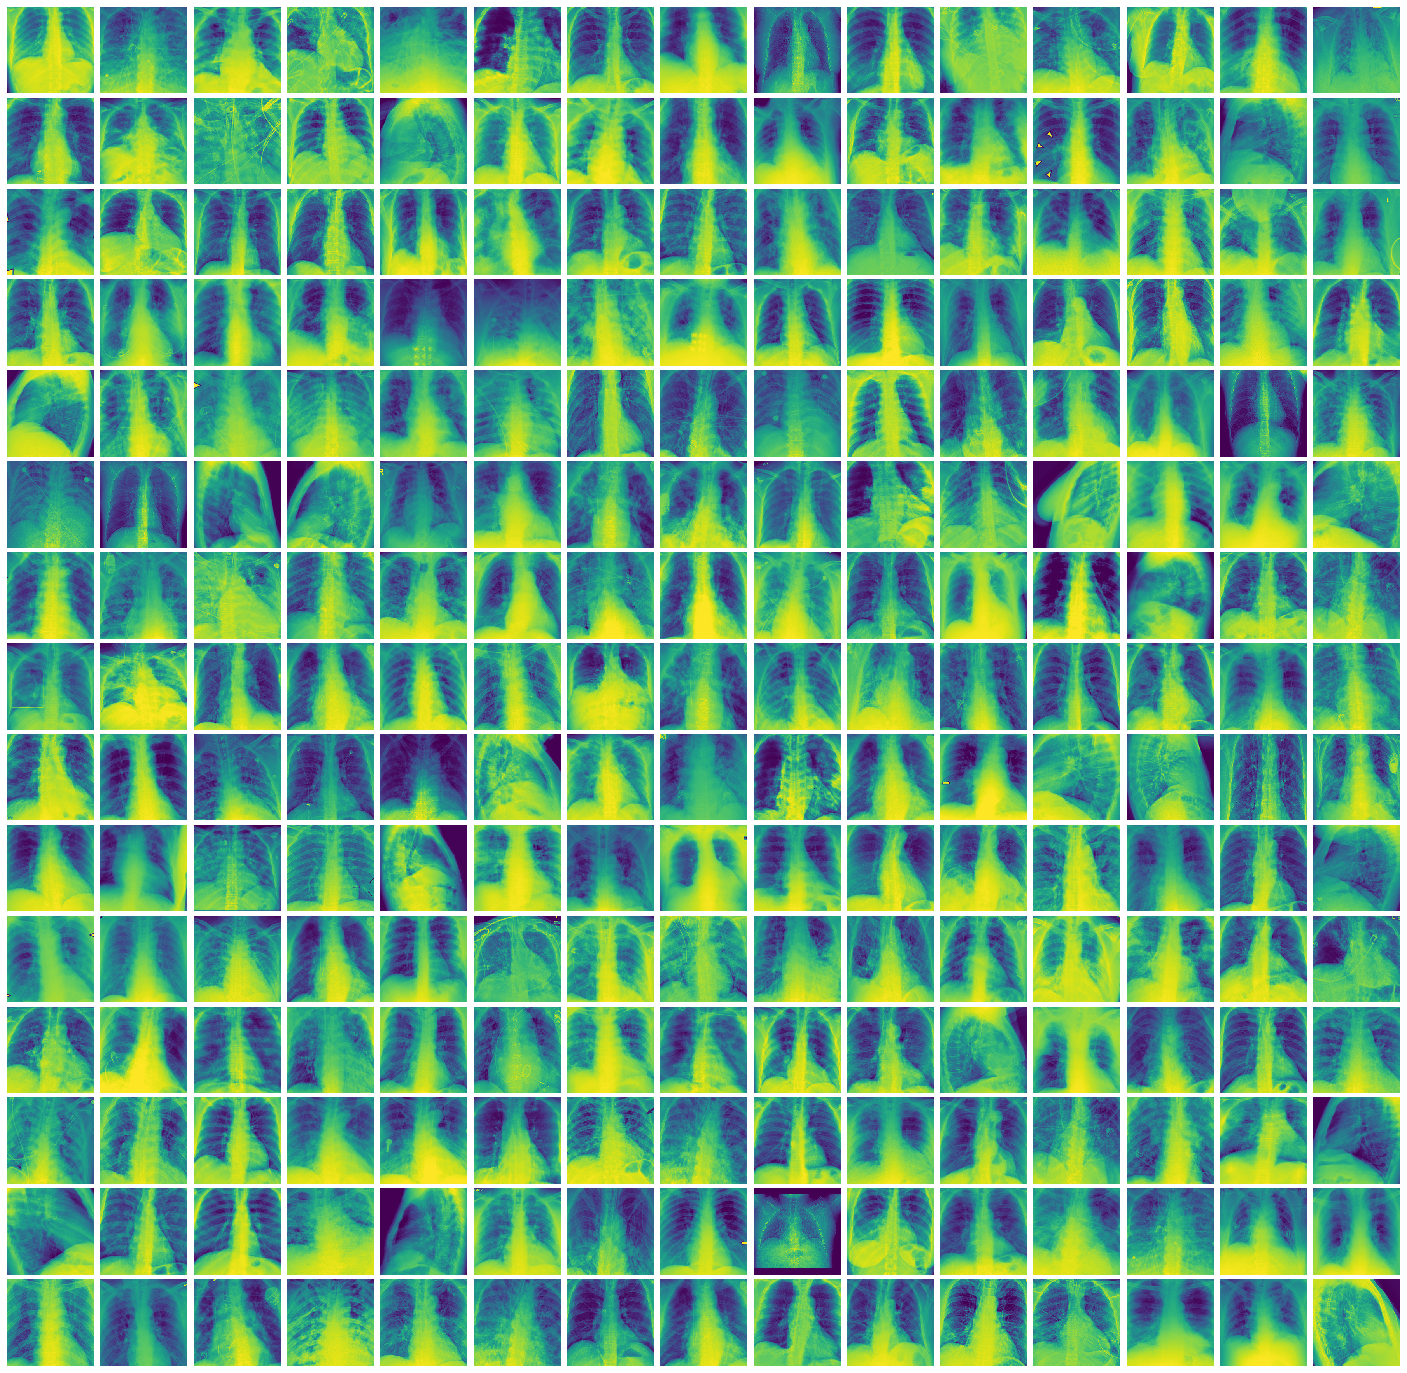

In [18]:
#Display images
print("COVID-19")
loader.ImageBase.montage(ims, figsize=(25,25))

np.random.seed(seed=42)
np.random.shuffle(ims)
np.random.shuffle(ims2)

#data = np.concatenate((ims, ims2[:len(ims)]), axis=0)
#label = np.concatenate((np.zeros((len(ims))), np.ones((len(ims)))), axis = 0)

data = np.concatenate((ims, ims2), axis=0)
label = np.concatenate((np.zeros((len(ims))), np.ones((len(ims2)))), axis = 0)

rest = ims2[len(ims):]
#restlabel = np.ones((len(rest)))
index = np.arange(0, len(label), 1)
np.random.shuffle(index)
data = data[index]
label = label[index]
#print("Number of covid samples = ", len(ims))
#print("Total samples =", len(label))
#print(data.shape, label.shape)

# Data Preprocessing

In [19]:
print("pre", data.shape)
X = gray2rgb(data)
#rest = gray2rgb(rest)
print("post", X.shape)
num_classes = 2
# Split into test,train & valid
x_train, x_test, y_train, y_test  = train_test_split(X,label, test_size=0.2) 
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)
# kf = KFold(n_splits=4)
# kf.get_n_splits(x_train)

#Normalize
# x_train = normalize(x_train,axis=1)
# x_test =  normalize(x_test,axis=1)
# x_valid =  normalize(x_valid,axis=1)
#x_rest = normalize(rest, axis=1)

#One hot
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes) 
y_valid = to_categorical(y_valid, num_classes) 
#y_rest = to_categorical(restlabel, num_classes)

# Add rest of unused images to test set
#x_test = np.concatenate((x_test, x_rest), axis=0)
#y_test = np.concatenate((y_test, y_rest), axis=0)

#del x_rest
#del y_rest

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

pre (2247, 224, 224)
post (2247, 224, 224, 3)
(1347, 224, 224, 3) (1347, 2)
(450, 224, 224, 3) (450, 2)
(450, 224, 224, 3) (450, 2)


In [33]:
print(y_train.shape)
print(np.where(y_train[:,1]==1)[0].shape)
print(np.where(y_valid[:,1]==1)[0].shape)
print(np.where(y_valid[:,1]==1)[0].shape)

(1347, 2)
(1205,)
(398,)
(398,)


# Data Augmentation

In [9]:
datagen = ImageDataGenerator(
  rotation_range=50, # Degree range for random rotations.
  width_shift_range=0.2, # How far you shift the image
  height_shift_range=0.2, # How far you shift the image
  shear_range=0,
  zoom_range=0.1, # How much you zoom the image
  fill_mode='constant' # Points outside the boundaries of the input are filled according to the given mode
)

covidargs = np.argwhere(np.argmax(y_train, axis=1)==0)

augmentedData = datagen.flow(
    x_train[covidargs.reshape(-1)],
    y_train[covidargs.reshape(-1)],
    batch_size=1,
    shuffle=False,
    seed=42,
)

x_aug = np.concatenate((x_train, augmentedData.x), axis = 0)
y_aug = np.concatenate((y_train, augmentedData.y), axis = 0)
print(x_train.shape, y_train.shape)
print(x_aug.shape, y_aug.shape)

(1044, 224, 224, 3) (1044, 2)
(1197, 224, 224, 3) (1197, 2)


# Create model, transfer weights and fit

In [13]:
def FitModel(model, x_train, y_train, NUM_EPOCHS = 20):
    
    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # Model fit
    r = model.fit(x=x_train, y=y_train,
     validation_data = (x_valid, y_valid),
     epochs= NUM_EPOCHS,
     callbacks=[callback],
     )
    return r

def TransferModel(net, x_train, y_train, iterations = 1):
    acc = []
    confusion = []
    accFine = []
    confusionFine = []
    for i in range(iterations):
        tf.keras.backend.clear_session()

        print("Transfer learning on model")
        base = net(weights='imagenet', include_top=False, input_shape=(imshape[0], imshape[1], 3))
        base.trainable = False

        LEARNING_RATE = 0.00001
        model = models.Sequential()
        model.add(base)
        model.add(layers.Flatten())
        model.add(layers.Dense(NO_NODES, activation='relu'))
        model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
        model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=LEARNING_RATE), metrics=['acc'])
        model.summary()

        # Train last layers
        print("Training last layers")
        result = FitModel(model, x_train, y_train)
        y_pred = result.model.predict(x_test)
        acc.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
        confusion.append(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


        # Unfreeze base model
        LEARNING_RATE = 0.00001
        base.trainable = True
        model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=LEARNING_RATE), metrics=['acc'])

        # Finetune all layers
        print("Fine-tuning all layers")
        result = FitModel(model, x_train, y_train)
        y_pred = result.model.predict(x_test)
        accFine.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
        confusionFine.append(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
        resultList.append(result)

        del model
        
    accList.append(acc)
    confusionList.append(confusion)
    accFineList.append(accFine)
    confusionFineList.append(confusionFine)
    
    
# Hyperparameters
NUM_CLASSES = 2
NO_NODES = 512
iterations = 1

accList = []
accFineList = []
confusionList = []
confusionFineList = []
resultList = []
modelNames = []

#print(x_aug.shape)
#print(x_train.shape)
#print(y_train.shape)
#print(y_aug.shape)

#Fine-tune different pre-trained networks
# TransferModel(VGG16, x_train, y_train, iterations)
# modelNames.append("VGG16")

# TransferModel(VGG19, x_train, y_train, iterations)
# modelNames.append("VGG19")

# TransferModel(InceptionV3, x_train, y_train, iterations)
# modelNames.append("InceptionV3")

# # TransferModel(ResNet50, x_train, y_train,iterations)
# # modelNames.append("ResNet50")

# TransferModel(InceptionResNetV2, x_train, y_train, iterations)
# modelNames.append("InceptionResNetV2")

# TransferModel(Xception, x_train, y_train, iterations)
# modelNames.append("Xception")

accList_NoAug = accList.copy()
accFineList_NoAug = accFineList.copy()
confusionList_NoAug = confusionList.copy()
confusionFineList_NoAug = confusionFineList.copy()

accList = []
accFineList = []
confusionList = []
confusionFineList = []


# # Fine-tune different pre-trained networks, augmented
# TransferModel(VGG16, x_aug, y_aug, iterations)
# modelNames.append("VGG16")

TransferModel(VGG19, x_aug, y_aug, iterations)
modelNames.append("VGG19")

# TransferModel(InceptionV3, x_aug, y_aug, iterations)
# modelNames.append("InceptionV3")

# # TransferModel(ResNet50, x_aug, y_aug,iterations)
# # modelNames.append("ResNet50")

TransferModel(InceptionResNetV2, x_aug, y_aug, iterations)
modelNames.append("InceptionResNetV2")

# TransferModel(Xception, x_aug, y_aug, iterations)
# modelNames.append("Xception")

accList_Aug = accList.copy()
accFineList_Aug = accFineList.copy()
confusionList_Aug = confusionList.copy()
confusionFineList_Aug = confusionFineList.copy()


Transfer learning on model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 32,870,978
Trainable params: 12,846,594
Non-trainable params: 20,024,384
_________________________________________________________________
Training last layers
Train on 1197 samples, validate on 348 samples
Epoch 1/20
1197/1197 [==============================] - 5s 4ms/sample - loss: 0.9326 - acc: 0.8680 - val_loss: 0.2911 - val_acc: 0.9540
Ep

In [14]:
def plotit(arr, confusion, plot=True):
    xax = np.arange((len(arr)))
    for x in range(len(arr)):
        if plot:
            plt.plot(arr[x], label = modelNames[x])
        s = modelNames[x] + "mean test accuracy: " + str(np.mean(arr[x])) + "    STD: " + str(np.std(arr[x]))
        print(s)
#         s = modelNames[x] + "mean val accuracy: " + str(np.mean(arr_val[x])) + "    STD: " + str(np.std(arr_val[x]))
#         print(s)
        print(confusion[x])
    if plot: 
        plt.legend()
        plt.show()
    bestarg = np.argmax(np.mean(arr, axis=1))
    print("Best Model:", modelNames[bestarg])
    #print(confusion[bestarg][np.argmax(arr[bestarg])])
    print("")
    
print("No. of covid positive in test set:",np.count_nonzero(y_test[:,0] == 1))

# Plot
print("No of nodes:", NO_NODES)
# print("------ Training of last layer ------")
# plotit(accList_NoAug, confusionList_NoAug, False)

# print("------ Fine-tuning of all layers ------")
# plotit(accFineList_NoAug, confusionFineList_NoAug, False)

print("------ Training of last layer, augmented ------")
plotit(accList_Aug, confusionList_Aug, False)

print("------ Fine-tuning of all layers, augmented ------")
plotit(accFineList_Aug, confusionFineList_Aug, False)

#print("x_test shape:", x_test.shape)

print("--- %s seconds ---" % (time.time() - start_time))

No. of covid positive in test set: 44
No of nodes: 512
------ Training of last layer, augmented ------
VGG19mean test accuracy: 0.9770114942528736    STD: 0.0
[array([[ 38,   6],
       [  2, 302]], dtype=int64)]
InceptionResNetV2mean test accuracy: 0.8735632183908046    STD: 0.0
[array([[  0,  44],
       [  0, 304]], dtype=int64)]
Best Model: VGG19

------ Fine-tuning of all layers, augmented ------
VGG19mean test accuracy: 0.9885057471264368    STD: 0.0
[array([[ 43,   1],
       [  3, 301]], dtype=int64)]
InceptionResNetV2mean test accuracy: 0.9827586206896551    STD: 0.0
[array([[ 44,   0],
       [  6, 298]], dtype=int64)]
Best Model: VGG19

--- 1021.6983633041382 seconds ---


# Gradcam

100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:08<00:00, 30.13it/s]


0.9885057471264368
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


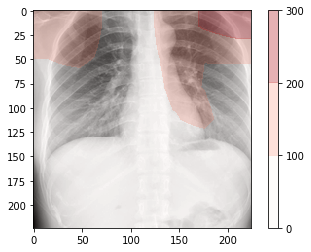

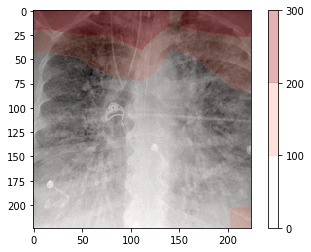

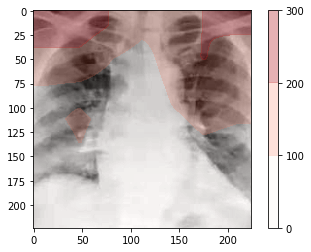

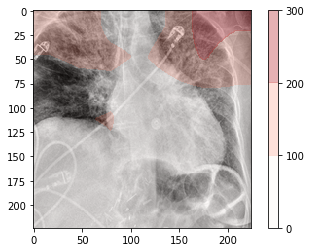

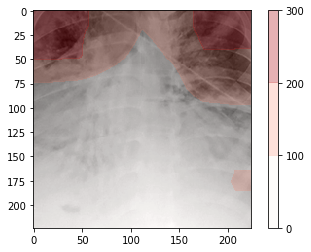

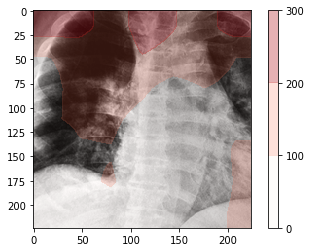

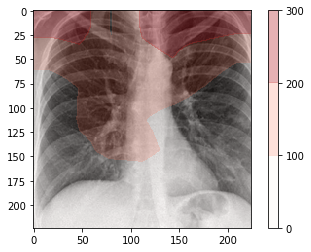

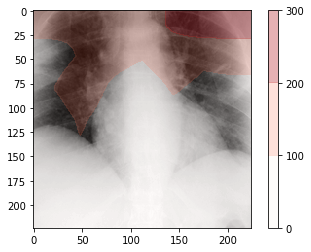

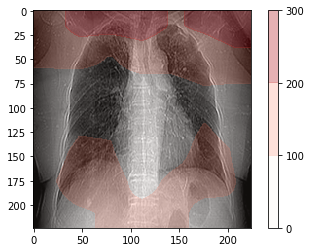

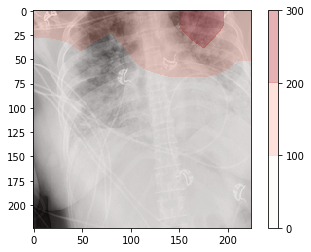

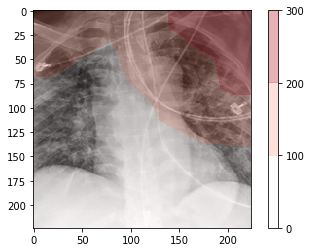

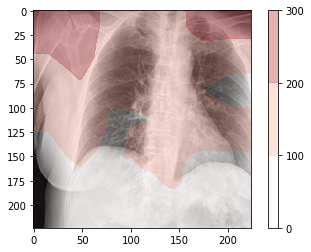

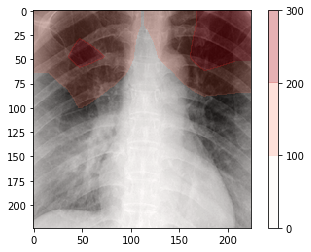

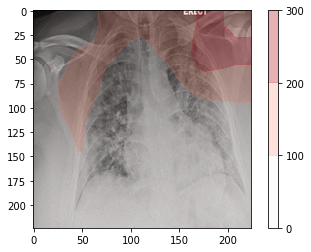

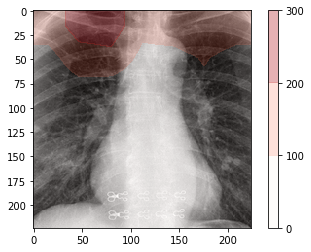

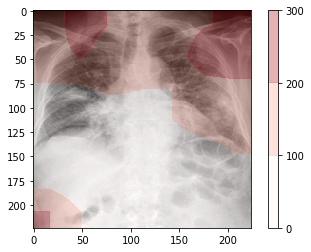

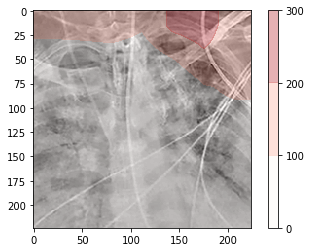

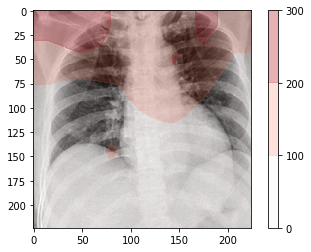

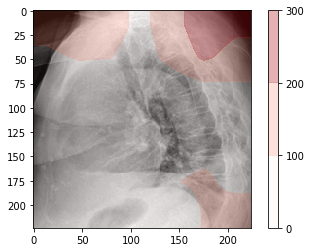

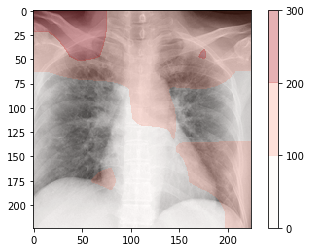

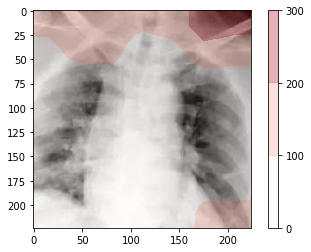

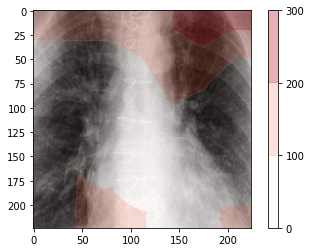

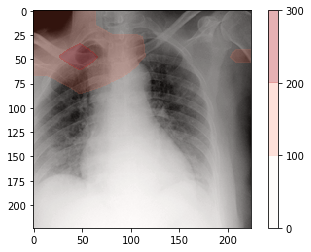

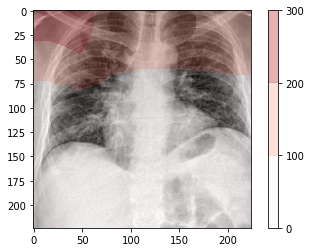

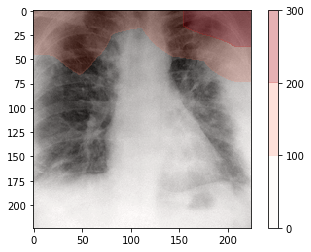

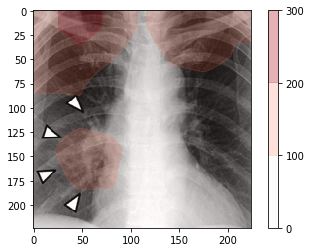

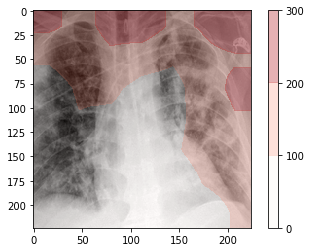

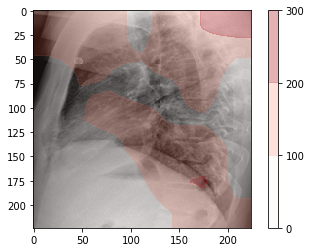

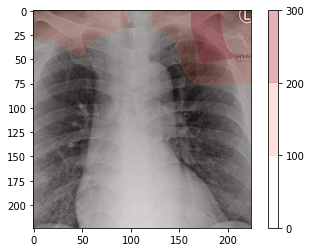

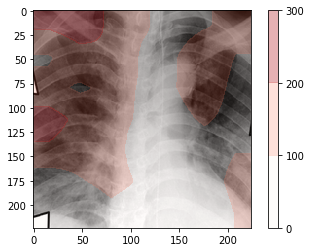

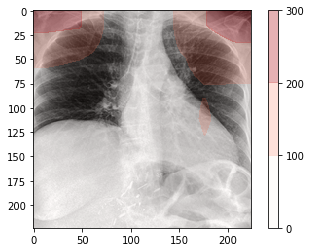

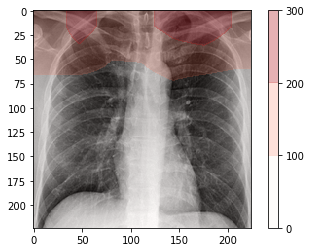

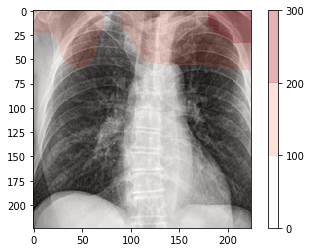

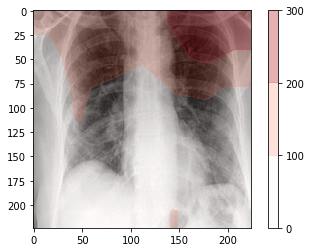

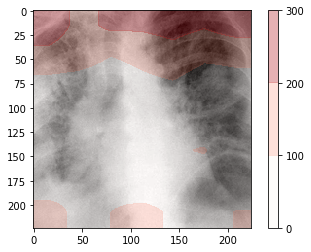

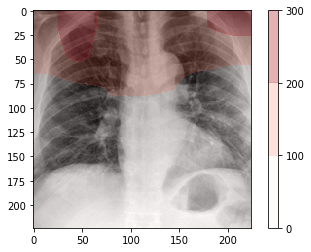

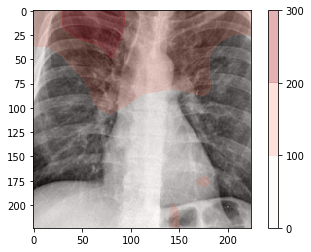

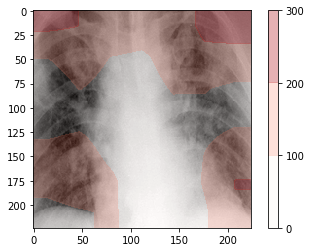

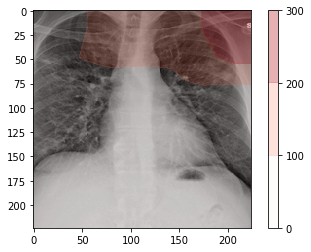

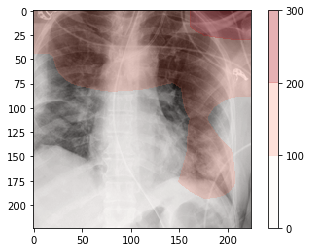

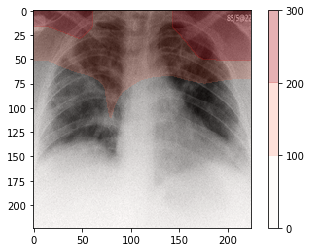

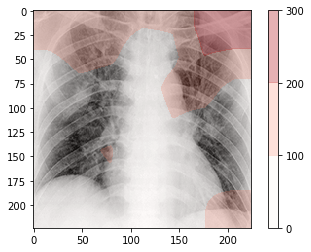

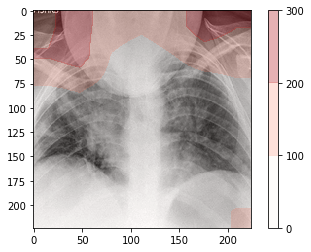

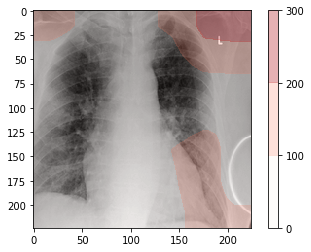

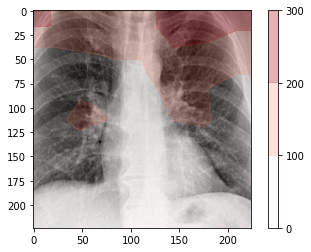

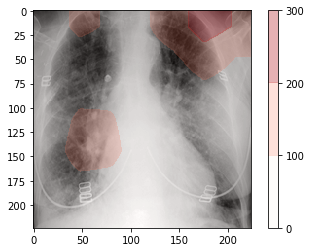

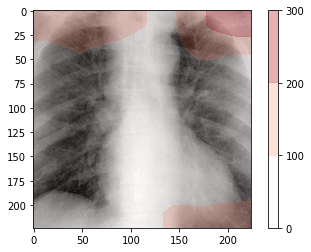

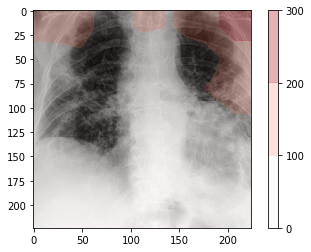

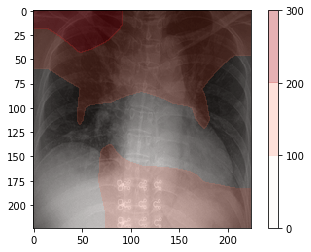

In [16]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.4, N+4)
    return mycmap
#Sample k covid images

IMSIZE = imshape
k = 50
ims = base.get_category(union = [{'modality' : ['X-ray']}], restrictions = [{'finding' : ['COVID-19', 'COVID-19, ARDS']}] , shape = getshape)
ims = crop_center(ims, imshape)

m = resultList[0]
y_pred = m.model.predict(x_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

rgbims = gray2rgb(ims)
preds = np.argmax(m.model.predict(rgbims), axis = 1)
print(preds)
import matplotlib.colors as mcolors
for i in range(k):
    if preds[i] == 0:
        cam = grad_cam.GradCAM(m.model, m.model.get_layer(index=0), preds[i], layerName=None)
        image = np.expand_dims(rgbims[i, :, :, :], axis=0)
        orig = ims[i, :, :]

        heatmap = cam.compute_heatmap(image)


        #Plot image and overlay colormap
        w, h = heatmap.shape
        y, x = np.mgrid[0:h, 0:w]   
        mycmap = transparent_cmap(plt.cm.Reds)
        fig, ax = plt.subplots(1, 1)
        b = ax.imshow(orig, cmap='gray')
        cb = ax.contourf(x, y, heatmap, 2, cmap=mycmap)
        plt.colorbar(cb)
        plt.show()
        
#         outfile = "figs/file_%d.jpg" % i
#         cv2.imwrite(outfile, b)